# Explore here

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


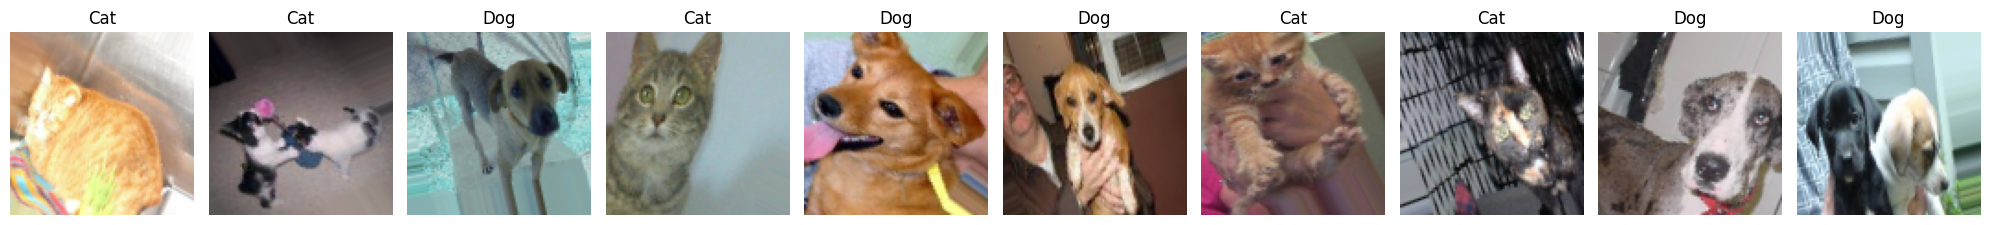

/tmp/ipykernel_1839/3983614411.py:78: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(100, 100, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15


/home/gitpod/.pyenv/versions/3.12.4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.8155 - loss: 0.4112 - val_accuracy: 0.8752 - val_loss: 0.2823
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 147ms/step - accuracy: 0.8591 - loss: 0.3093 - val_accuracy: 0.8782 - val_loss: 0.2757
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 147ms/step - accuracy: 0.8695 - loss: 0.2981 - val_accuracy: 0.8802 - val_loss: 0.2648
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.8723 - loss: 0.2922 - val_accuracy: 0.8846 - val_loss: 0.2640
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 146ms/step - accuracy: 0.8709 - loss: 0.2962 - val_accuracy: 0.8804 - val_loss: 0.2693
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 147ms/step - accuracy: 0.8731 - loss: 0.2831 - val_accuracy: 0.8848 - val_loss: 0.2578
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 146ms/step - accuracy: 0.8826 - loss: 0.2764 - val_accuracy: 0.8868 - val_loss: 0.2619
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 171ms/step - accuracy: 0.8769 - loss: 0.2816 - 

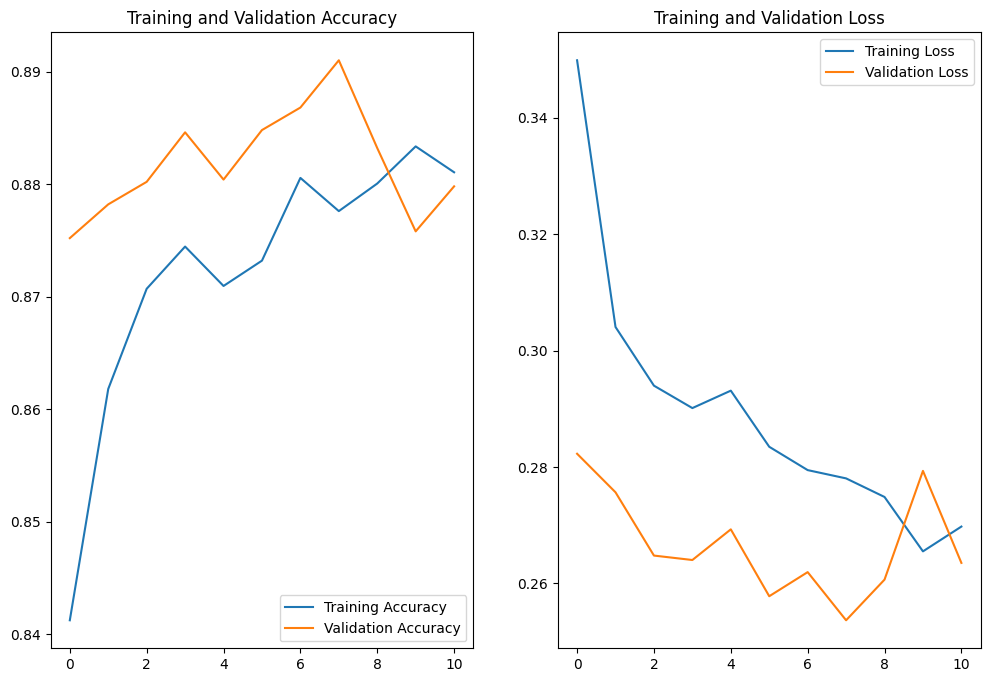

391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step


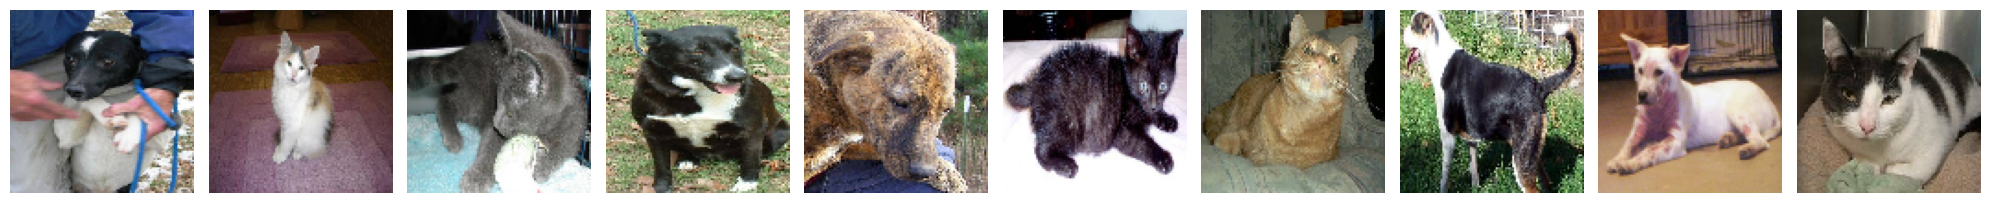

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]


In [35]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
import os
from PIL import Image

# Directorios
train_dir = '../data/raw/train'
test_dir = '../data/raw/test1'

# Configuración de los generadores de datos con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),  # Tamaño reducido para entrenamiento más rápido
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Generador de datos de validación
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),  # Tamaño reducido para entrenamiento más rápido
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Generador de datos de prueba (sin etiquetas)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='../data/raw/',
    classes=['test1'],
    target_size=(100, 100),  # Tamaño reducido para entrenamiento más rápido
    batch_size=32,
    class_mode=None,  # No hay etiquetas
    shuffle=False
)

# Mostrar algunas imágenes de entrenamiento
def plot_images(images_arr, labels_arr=None, preds_arr=None):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img)
        ax.axis('off')
        if labels_arr is not None:
            title = 'Cat' if labels_arr[i] == 0 else 'Dog'
            if preds_arr is not None:
                pred = 'Cat' if preds_arr[i] == 0 else 'Dog'
                title += f'/{pred}'
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Obtener un lote de imágenes de entrenamiento
images, labels = next(train_generator)
plot_images(images[:10], labels[:10])

# Crear el modelo usando MobileNetV2 como base
base_model = MobileNetV2(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar las capas del modelo base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_transfer.keras', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=15,  # Entrenar durante 15 épocas
    callbacks=[early_stopping, model_checkpoint]
)

# Graficar pérdida y precisión
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

# Cargar el mejor modelo guardado
model.load_weights('model_transfer.keras')

# Realizar predicciones sobre el conjunto de pruebas
predictions = model.predict(test_generator)
predicted_classes = [1 if p > 0.5 else 0 for p in predictions]  # Ajustar según sea perro (1) o gato (0)

# Opcional: Mostrar algunas predicciones
test_images = next(test_generator)  # Solo obtenemos las imágenes sin etiquetas
plot_images(test_images[:10], preds_arr=predicted_classes[:10])
print(predicted_classes[:10])